In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc
import squidpy as sq
from pathlib import Path
import geopandas as gpd
import os


# Preparing data

In [34]:
# Preparing variables
fig_out = Path("/Users/janzules/Roselab/Spatial/CAR_T/figures/Moran_results/")
sample = "CyPSCA_1_2"


In [2]:
segmentation_path = Path("/Users/janzules/Roselab/Spatial/CAR_T/data/cell_segmentation/")
adata_file     = segmentation_path / "concatenated" / "combined_adata.h5ad"
geneList = segmentation_path / "Gene_lists"
fig_out = Path("/Users/janzules/Roselab/Spatial/CAR_T/figures/clustering_results/")
ST_sample_org = sc.read_h5ad(adata_file)

ST_sample = ST_sample_org[ST_sample_org.obs['mouse'].isin([sample])].copy()
del ST_sample_org

In [26]:
gdf_file = segmentation_path /  "concatenated" / "combined_nuclei_geometry.gpkg"
geo_file = gpd.read_file(gdf_file)

In [ ]:
gdf = geo.merge(ST_sample.obs[['id', 'n_counts']], on='id', how='inner')

In [4]:
# move cx, cy from obs to obsm["spatial"]
ST_sample.obsm["spatial"] = ST_sample.obs[["cx", "cy"]].to_numpy()


In [6]:
sq.gr.spatial_neighbors(
    ST_sample,
    coord_type="generic",        # using your cx/cy coords
    n_neighs=6                  # ≈ 6 nearest neighbors in space
)


In [7]:
sq.gr.spatial_autocorr(
    ST_sample,
    mode="moran",                # Moran’s I
    n_perms=500,                 # number of permutations
    genes=ST_sample.var_names,   # you can pre‐filter HVGs here
)


/Users/janzules/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/scanpy/metrics/_common.py:72: UserWarning: 3397 variables were constant, will return nan for these.
  warnings.warn(
  0%|                                                                               | 0/500 [00:00<?, ?/s]/Users/janzules/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/scanpy/metrics/_common.py:72: UserWarning: 3397 variables were constant, will return nan for these.
  warnings.warn(
/Users/janzules/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/janzules/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureW

In [45]:
moran["I"].describe()

count    19059.000000
mean         0.143217
std          0.155722
min          0.005369
25%          0.005369
50%          0.063795
75%          0.273778
max          0.500998
Name: pval_sim_fdr_bh, dtype: float64

In [47]:
# Directly extract the moranI DataFrame
moran = ST_sample.uns["moranI"]

# Use one of the corrected FDR-adjusted columns
# e.g. pval_sim_fdr_bh is adjusted p-value for permutation test
top20 = moran.sort_values(["I", "pval_sim_fdr_bh"], ascending=[False, True]).head(20)
print(top20[['I', 'pval_sim_fdr_bh']])
print(top20)


               I  pval_sim_fdr_bh
Gbp2    0.256431         0.005369
Cd74    0.237352         0.005369
Col1a2  0.233098         0.005369
Col1a1  0.221976         0.005369
Apoe    0.206503         0.005369
S100a4  0.202030         0.005369
Irgm1   0.193186         0.005369
Cxcl10  0.189018         0.005369
H2-Aa   0.187614         0.005369
Vim     0.184157         0.005369
Rsad2   0.181236         0.005369
H2-Eb1  0.180806         0.005369
H2-Ab1  0.175577         0.005369
Isg15   0.175172         0.005369
Cxcl9   0.174383         0.005369
Rap1b   0.173938         0.005369
Clu     0.173092         0.005369
mt-Co2  0.171945         0.005369
Ifng    0.171527         0.005369
S100a6  0.171074         0.005369
               I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
Gbp2    0.256431        0.0   0.00002         0.0  0.001996  0.000023   
Cd74    0.237352        0.0   0.00002         0.0  0.001996  0.000020   
Col1a2  0.233098        0.0   0.00002         0.0  0.001996  0.0000

In [ ]:
for gene in top20.index:
    sc.pl.spatial(
        ST_sample,
        color=gene,
        coord_key=["cx", "cy"],
        cmap="viridis",
        size=5,
        show=False
    )
    plt.title(f"{gene} (Moran’s I = {moran.loc[gene,'I']:.2f})")
    plt.tight_layout()
    plt.show()

In [23]:
ST_sample.obsm['spatial']

array([[3140.39615276, 4719.0972765 ],
       [3316.63437694, 4619.74353578],
       [3232.5008801 , 4538.45545945],
       ...,
       [7768.67341604, 6420.29968138],
       [7742.46044796, 6518.35937051],
       [7706.82565149, 6281.61089437]], shape=(15259, 2))

In [32]:
# quick dual-gradient plot: ISG score vs COL1A1
ST_sample.obs["isg_score"] = ST_sample[:, ["Gbp2","Irgm1","Isg15","Ifit3","Rsad2"]].X.mean(1)

# Case A: Col1a1 is in .X (default)
ST_sample.obs["Col1a1"] = ST_sample[:, "Col1a1"].X.toarray().flatten()

# Case B: if you were using .raw and normalized counts were stored there
# ST_sample.obs["Col1a1"] = ST_sample.raw[:, "Col1a1"].X.toarray().flatten()


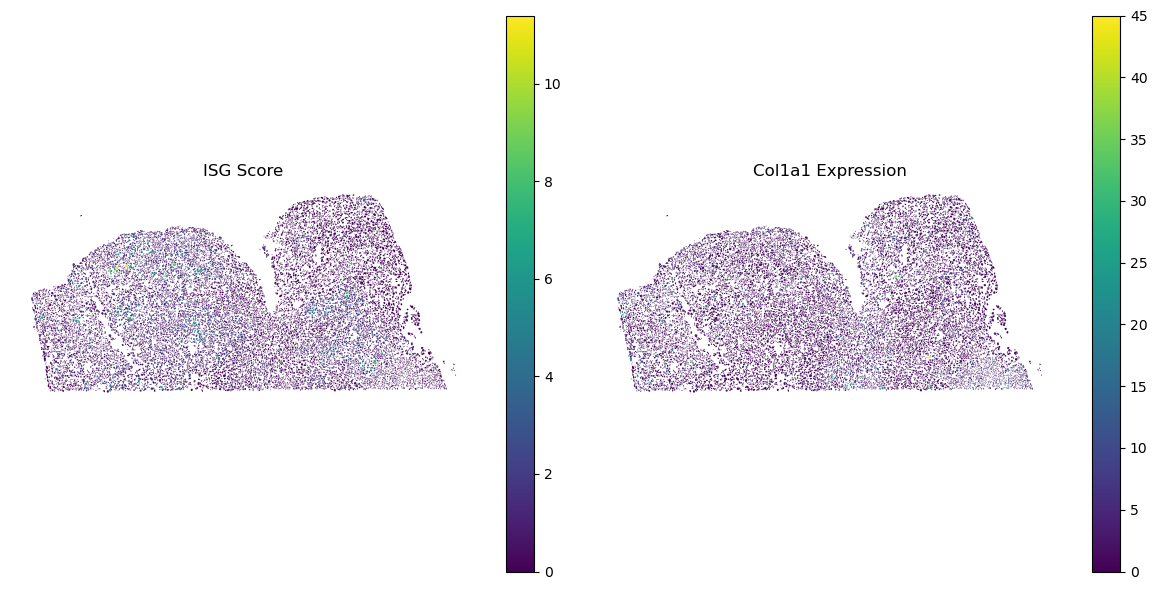

In [33]:
# 1. Restrict to current sample’s nuclei
gdf = geo_file.merge(
    ST_sample.obs[["id", "isg_score", "Col1a1"]],
    on="id",
    how="inner"
)

# 2. Plot both modules using polygons
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

gdf.plot("isg_score", ax=axs[0], cmap="viridis", legend=True)
axs[0].set_title("ISG Score")
axs[0].axis("off")

gdf.plot("Col1a1", ax=axs[1], cmap="viridis", legend=True)
axs[1].set_title("Col1a1 Expression")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [37]:

# Make sure output directory exists
output_dir = fig_out / sample
output_dir.mkdir(parents=True, exist_ok=True)

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot each module
gdf.plot("isg_score", ax=axs[0], cmap="inferno", legend=True)
axs[0].set_title("ISG Score")
axs[0].axis("off")

gdf.plot("Col1a1", ax=axs[1], cmap="inferno", legend=True)
axs[1].set_title("Col1a1 Expression")
axs[1].axis("off")

# Layout and save
plt.tight_layout()
fig_path = output_dir / "ISG_vs_Col1a1_polygon_plot.png"
plt.savefig(fig_path, dpi=600, bbox_inches="tight")
plt.close(fig)

print(f"Figure saved to: {fig_path}")


Figure saved to: /Users/janzules/Roselab/Spatial/CAR_T/figures/Moran_results/CyPSCA_1_2/ISG_vs_Col1a1_polygon_plot.png
